# Test trained neural density estimator

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from evo_models import WF, WF_bottleneck, WF_DFE
import pickle
import torch
import matplotlib 
from seaborn import histplot

def change_font(fontsize):
    matplotlib.rcParams['xtick.labelsize'] = fontsize
    matplotlib.rcParams['ytick.labelsize'] = fontsize
    matplotlib.rcParams['font.size'] = fontsize


In [2]:
from sbi.inference import NPSE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from inference_utils import get_prior
from inference import simulator

# Check prior, return PyTorch prior.
prior = get_prior()
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

num_sims = 10_000

theta = prior.sample((num_sims,))
x = simulator(theta)

inference = NPSE(prior, sde_type="ve")
_ = inference.append_simulations(theta, x).train()
posterior_npse = inference.build_posterior()


KeyboardInterrupt: 

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

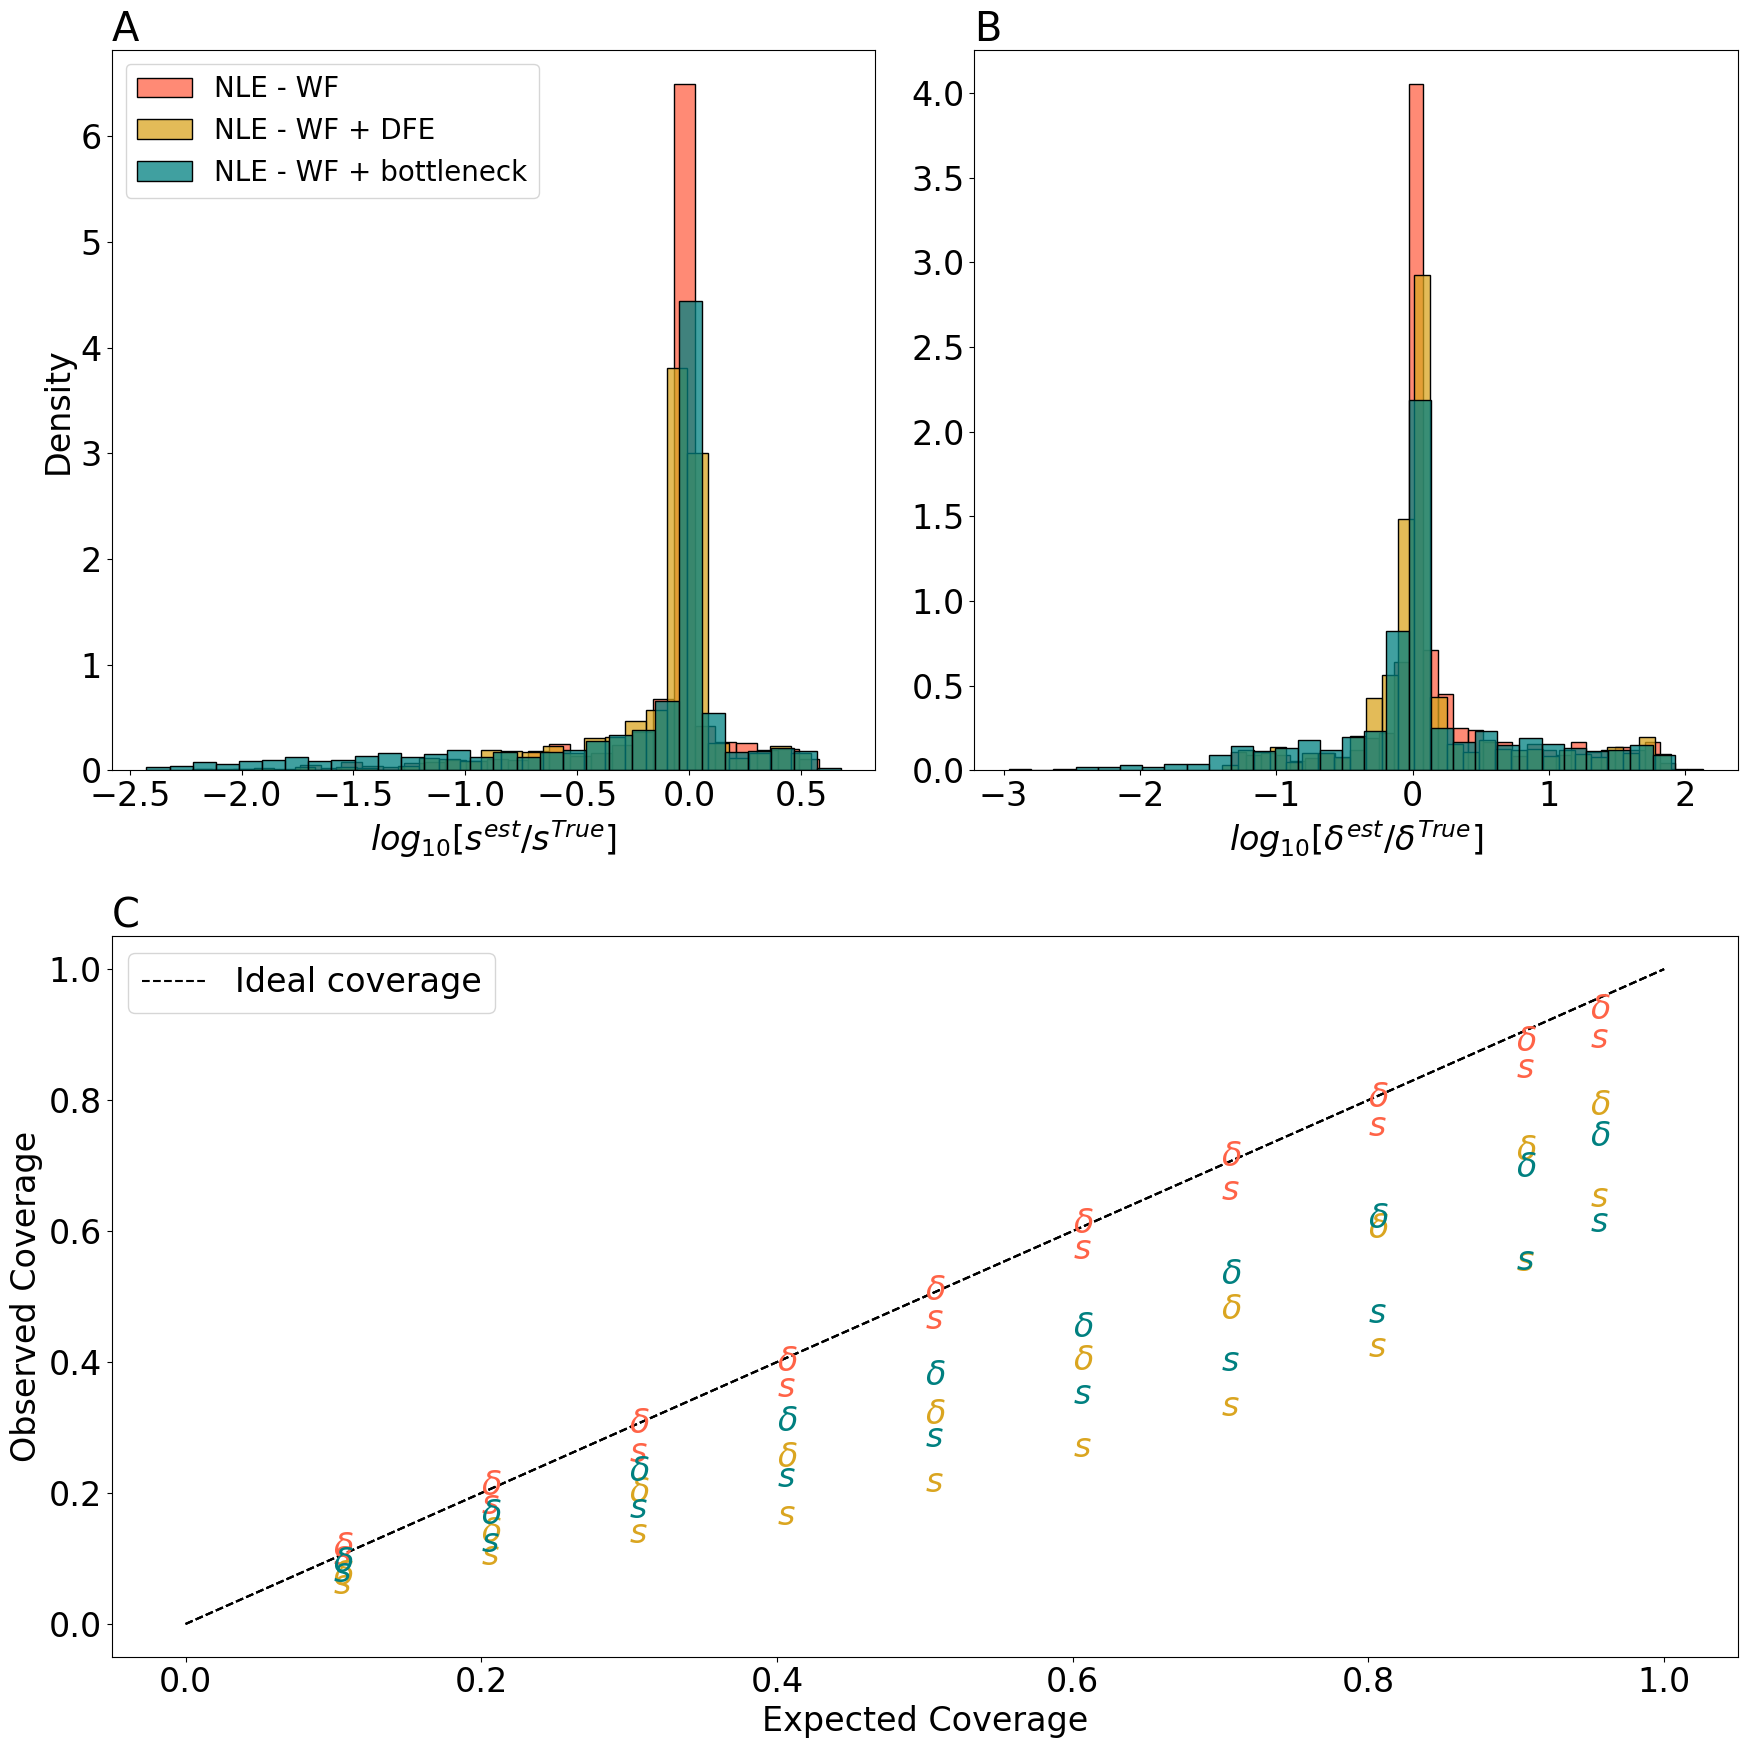

In [61]:
change_font(24)

def accuracy(samples, thetas):
    accs = torch.empty(len(thetas),len(thetas[0]))
    for i in range(len(thetas)):
        samps = samples[:,i]
        accs[i] = samps.mean(0) - thetas[i]
    return accs

def plot_accuracy(ax, accs, color, label):
    for i in range(len(ax)):
        histplot(accs[:,i],ax=ax[i], stat='density', color=color, bins=30, label=label)
    return


def coverage_old(samples, thetas, conf_levels=[0.1*i for i in range(1,10)] +[0.95]):
    covs = torch.empty(len(conf_levels), len(thetas), len(thetas[0]))
    for j in range(len(conf_levels)):
        conf_level = conf_levels[j]   
        taken_samples = samples[:int(conf_level*len(samples))+1]
        hdi = [torch.quantile(samples, (1-conf_level)/2, 0), torch.quantile(samples,(1+conf_level)/2, 0)]
        covs[j,:] = ((thetas > hdi[0])*(thetas < hdi[1]))
    return covs.mean(1)

        
def plot_results(model, architecture, color, fig, ax):

    ax['A'].set_title('A',loc='left')
    ax['B'].set_title('B',loc='left')
    ax['C'].set_title('C',loc='left')

    ax['C'].plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Ideal coverage' if model=='WF' else '', ls='--')
    ax['C'].set_xlabel('Expected Coverage')
    ax['C'].set_ylabel('Observed Coverage')
    ax['C'].legend()

    ax['A'].set_xlabel('$log_{10}[s^{est} / {s^{True}}]$')
    ax['B'].set_xlabel('$log_{10}[δ^{est} / {δ^{True}}]$')

    axx = [ax['A'], ax['B']]
    
    samples = torch.load(f'test_sims/samples_{model}_{architecture}.pt')
    thetas = torch.load(f'test_sims/test_theta_{model}.pt')
    posterior = pickle.load(open(f'posteriors/posterior_{architecture}.pkl', 'rb'))
    
    accs = accuracy(samples, thetas)
    
    
    plot_accuracy(axx, accs, color=color, label=f'{architecture.upper()} - {model.replace("_", " + ")}')
    conf_levels=[0.1*i for i in range(1,10)] +[0.95]
    covs = coverage_old(samples, thetas, conf_levels)
    params =  ['$s$', '$δ$']
    for i in range(len(params)):
        for j in range(len(covs)):
            ax['C'].text(conf_levels[j], covs[j,i], params[i], color=color)
    
    ax['A'].legend(loc='upper left', fontsize=20)
    ax['C'].legend()
    ax['B'].set_ylabel('')
    
    return

mosaic = '''AB
            CC
            '''
fig, ax = plt.subplot_mosaic(mosaic,figsize=(18,18), tight_layout=True)

plot_results('WF', 'nle', 'tomato', fig, ax)
plot_results('WF_DFE', 'nle', 'goldenrod', fig, ax)
plot_results('WF_bottleneck', 'nle', 'teal', fig, ax)


In [40]:
thetas = torch.load(f'test_sims/theta.pt')
xs = torch.load(f'test_sims/x.pt')
posterior = pickle.load(open(f'posteriors/posterior_{architecture}.pkl', 'rb'))
s = 10**thetas[2,0].item()
mu = 10**thetas[2,1].item()
WF(s,mu, int(1e8), 200), xs[2]

(array([0.10214494, 0.96735757, 0.99986982, 0.9999995 , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ]),
 tensor([0.1021, 0.9674, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]))

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\nadav\AppData\Local\Temp\ipykernel_28868\2268780431.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('$\mu$')


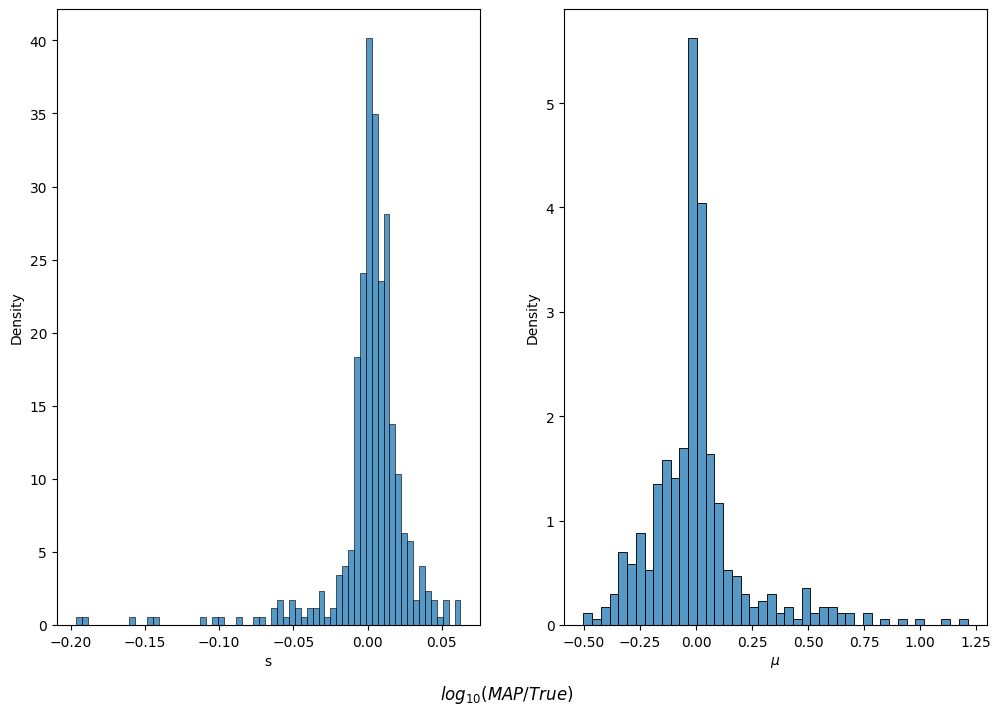

In [4]:
def plot_test_results(test_results):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    sns.histplot(test_results['s'], ax = ax[0], stat='density')
    sns.histplot(test_results['mu'], ax = ax[1], stat='density')
    fig.supxlabel('$log_{10}({MAP}/{True})$')
    ax[0].set_xlabel('s')
    ax[1].set_xlabel('$\mu$')
plot_test_results(test_results)

In [5]:
%%capture
# Fast coverage function
import torch
def coverage(posterior, X, theta):
    covs = []
    for i in range(len(X)):
        samples = posterior.set_default_x(X.iloc[i,:]).sample((200,))
        params = torch.tensor(theta.iloc[i,:], dtype=torch.float32)
        covs.append((posterior.log_prob(samples) > posterior.log_prob(params)).sum()/200)
    return np.array(covs)

covs = coverage(posterior, X, theta)

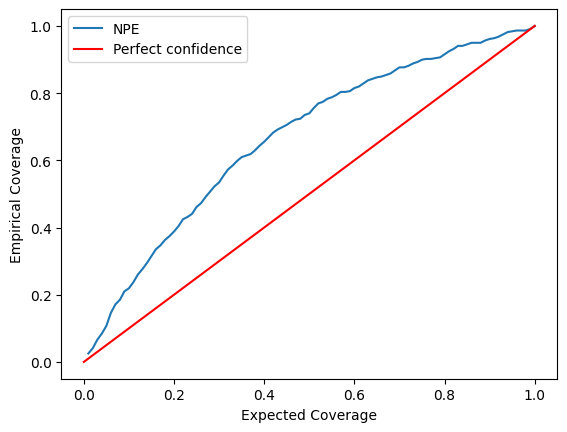

In [6]:
def plot_coverage(covs):
    H,X1 = np.histogram(covs, bins = 100, range = (0,1), density = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    plt.plot(X1[1:], F1, label = 'NPE')
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='red', label='Perfect confidence')
    plt.xlabel('Expected Coverage')
    plt.ylabel('Empirical Coverage')
    plt.legend()
plot_coverage(covs)

In [7]:
%%capture
# Test on simulations from another model - DFE

X_DFE = pd.read_csv('test_sims/WF_DFE_sims.csv').iloc[:400,:]
theta_DFE = pd.read_csv('test_sims/WF_DFE_thetas.csv').iloc[:400,:]
theta = pd.read_csv('test_sims/WF_DFE_thetas.csv').iloc[:400,:]
# Realistic test
theta_DFE = theta[X_DFE.iloc[:,-1] > 0.2]
X_DFE = X_DFE[X_DFE.iloc[:,-1] > 0.2]

test_results_DFE = test_estimator(posterior, X_DFE, theta_DFE, output_file_name='test_results_DFE.csv')

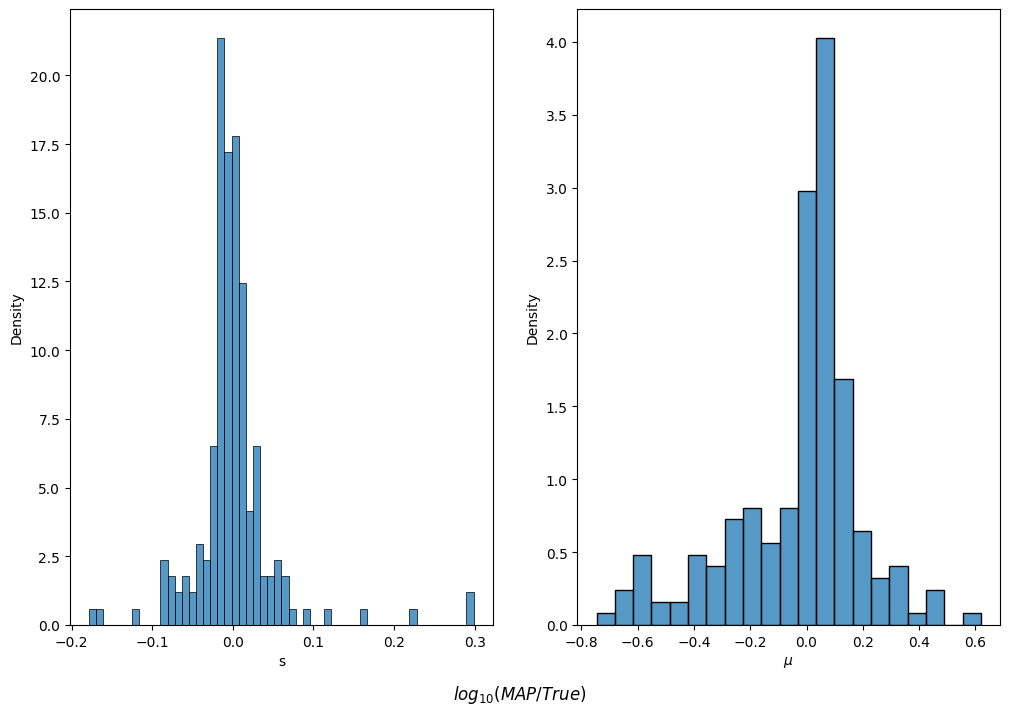

In [8]:
plot_test_results(test_results_DFE)

In [9]:
%%capture
covs_DFE = coverage(posterior, X_DFE, theta_DFE)

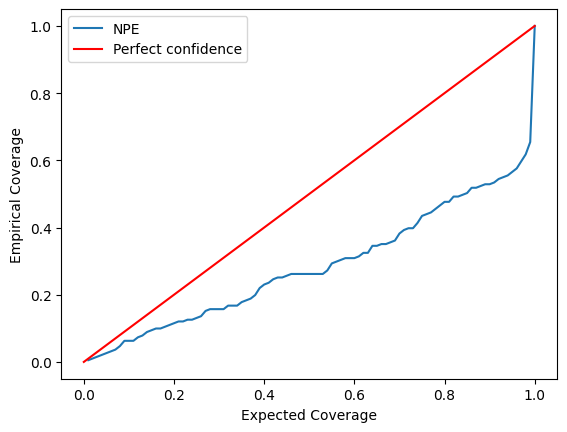

In [10]:
plot_coverage(covs_DFE)

In [11]:
%%capture
# Test on simulations from another model - bottleneck

X_bottleneck = pd.read_csv('test_sims/WF_bottleneck_sims.csv')
theta_bottleneck = pd.read_csv('test_sims/WF_bottleneck_thetas.csv')
# Realistic test
theta_bottleneck = theta_bottleneck[X_bottleneck.iloc[:,-1] > 0.2]
X_bottleneck = X_bottleneck[X_bottleneck.iloc[:,-1] > 0.2]

test_results_bottleneck = test_estimator(posterior, X_bottleneck, theta_bottleneck, output_file_name='test_results_bottleneck.csv')

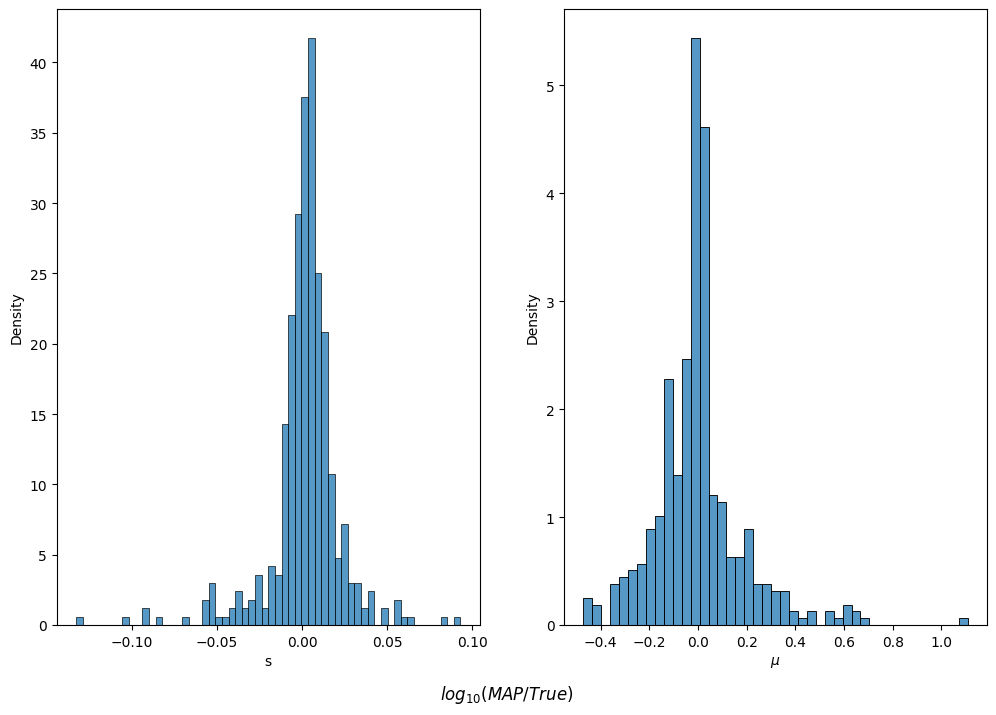

In [18]:
plot_test_results(test_results_bottleneck)

In [14]:
%%capture
X_bottleneck = pd.read_csv('test_sims/WF_bottleneck_sims.csv')
theta_bottleneck = pd.read_csv('test_sims/WF_bottleneck_thetas.csv')
covs_bottleneck = coverage(posterior, X_bottleneck, theta_bottleneck)

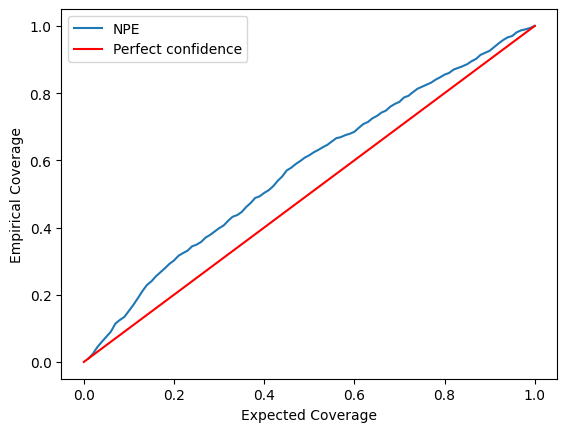

In [15]:
plot_coverage(covs_bottleneck)

In [31]:
# %%capture
# Test on simulations from another model - frequency-dependent selection
posterior = RejectionPosterior(posterior.potential_fn, proposal=get_prior())
X_FD = pd.read_csv('test_sims/WF_FD_sims.csv')
theta_FD = pd.read_csv('test_sims/WF_FD_thetas.csv')
# Realistic test
theta_FD = theta_FD[X_FD.iloc[:,-1] > 0.2].iloc[5:]
X_FD = X_FD[X_FD.iloc[:,-1] > 0.2].iloc[5:]

test_results_FD = test_estimator(posterior, X_FD, theta_FD, output_file_name='test_results_FD.csv')

c:\Users\nadav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sbi\utils\user_input_checks.py:584: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = atleast_2d(torch.as_tensor(x, dtype=float32))


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\nadav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sbi\utils\user_input_checks.py:584: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = atleast_2d(torch.as_tensor(x, dtype=float32))


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Optimization was interrupted after 48 iterations. 


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [1]:
plot_test_results(test_results_FD)

NameError: name 'plot_test_results' is not defined

In [ ]:
%%capture
covs_FD = coverage(posterior, X_FD, theta_FD)

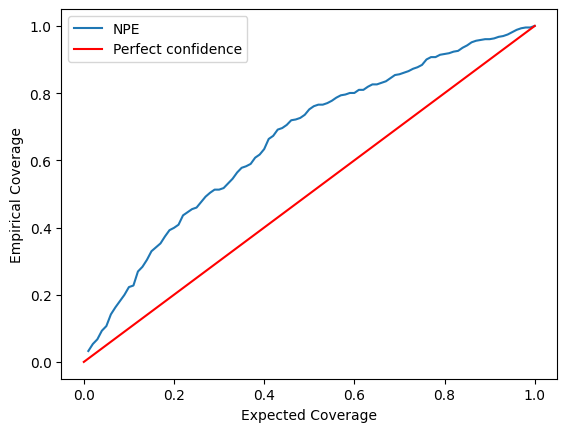

In [ ]:
plot_coverage(covs_FD)